In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from flask import Flask, request, jsonify

In [3]:
# Data Preprocessing
dataset_path = 'C:/Users/admin/Task1/customer_churn_large_dataset.xlsx'
data = pd.read_excel(dataset_path)
data = data.drop(['CustomerID', 'Name', 'Location'], axis=1)
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])
X = data.drop('Churn', axis=1)
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# Downsampling the data
# Choosing a subset of the data for hyperparameter tuning
subset_size = 5000
X_train_subset = X_train_scaled[:subset_size]
y_train_subset = y_train[:subset_size]

In [5]:
# Define the search space for Bayesian Optimization
param_space = {
    'n_estimators': Integer(100, 300),
    'max_depth': Integer(1, 20),
}

In [6]:
# Initialize the Bayesian Search CV
bayes_search = BayesSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    search_spaces=param_space,
    n_iter=30,
    cv=3,
    n_jobs=-1
)

In [7]:
# Fit the Bayesian Search CV on the subset
bayes_search.fit(X_train_subset, y_train_subset)

C:\Users\admin\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\admin\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\admin\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\admin\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\admin\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
              n_iter=30, n_jobs=-1,
              search_spaces={'max_depth': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=300, prior='uniform', transform='normalize')})

In [8]:
# Get the best model and its parameters
best_model = bayes_search.best_estimator_
best_params = bayes_search.best_params_

In [9]:
# Train and evaluate the best model on the full test set
best_model.fit(X_train_scaled, y_train)
y_pred_best = best_model.predict(X_test_scaled)
classification_rep_best = classification_report(y_test, y_pred_best)
print(f"Best Model Classification Report:\n{classification_rep_best}")

Best Model Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      0.84      0.63     10079
         1.0       0.50      0.16      0.24      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.43     20000
weighted avg       0.50      0.50      0.44     20000



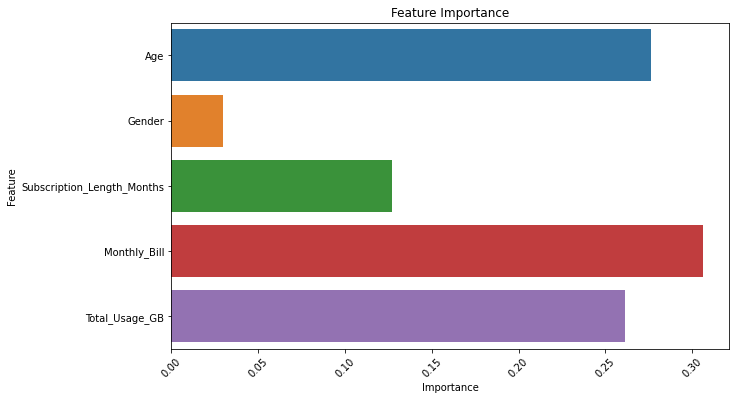

In [10]:
# Visualize Feature Importance
feature_importance = best_model.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xticks(rotation=45)
plt.show()

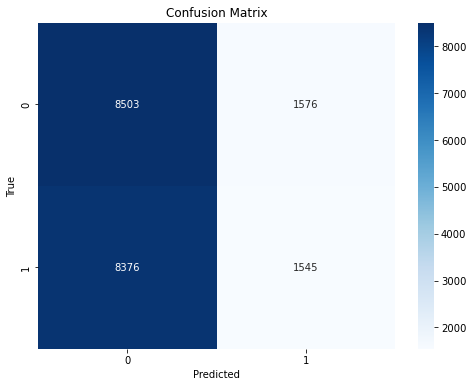

In [14]:
# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [15]:
# Model Deployment using Flask
app = Flask(__name__)

In [16]:
@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    features = np.array(data['features']).reshape(1, -1)
    scaled_features = scaler.transform(features)
    prediction = best_model.predict(scaled_features)[0]
    return jsonify({'prediction': prediction})